# Assignment 5 - ML diagnosis

Suppose we train a model and it does well on the training set, after that we have to assess if it can generalize well to unseen data. We can diagnose the quality of ML methods just by comparing training $E_{t}$ with validation $E_{v}$ errors. This diagnosis can be further developed if a benchmark (or reference) error level $E_{ref}$ exists. You can read more about it in **Section 6.6** of the course book.

There are several cases of errors comparison:

**1.** $E_{t}\approx E_{v}\approx E_{ref}$: All the errors are on the same level, so the ML method works rather good and there is no need to improve it further.

**2.** $E_{t}\ll E_{v}$: The validation error is larger than the the training error. That means that the model faces overfitting. That can be solved either by reducing the effective size of the hypothesis space or increasing the effective
number of training data points. **That is the most common case which is checked in the process of model learning.**

**3.** $E_{t}\approx E_{v}\gg E_{ref}$: Training and validation errors are same, but they are much larger than the reference error. In that case the model does not overfit, but it in general performs bad, i.e. it is underfitting the training data. Two commonly used strategies to conquer underfitting are choosing a larger hypothese space and collecting more relevant features.

**4.** $E_{t}\gg E_{v}$: The situation of having training error significantly larger than validation one is not so common.  The increase of training and validation sets sizes by collecting more labeled data points or
using data augmentation can increase the performance here. On the contrary, $E_{t}> E_{v}$ is not rare, even if the dataset is not small, you are highly likely to see it in your practicing. It usually is due to unlucky splitting combined with underfitting, the former can be mitigated by Kfold CV, the latter may be solved by enlarging hypothesis space and/or collecting more relevant features.


## Learning goals
After successfully completing this assignment, you should:

* Understand the basic workflow of training, selecting and testing ML models.
* Be aware of random fluctuations in validation error (due to unlucky splits).
* Know some means for getting a baseline/benchmark/reference value to compare against the obtained average loss on validation/test set.

In [1]:
# Import basic libraries needed for this assignment
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np #import numpy to work with arrays
import pandas as pd #import pandas to manipulate the dataset
from matplotlib import pyplot as plt #import the module matplotlib.pyplot to do visulization
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

<div class=" alert alert-warning">
    
# Task A5.1:
<ul>
The data in the correctly organized ML workflow should be divided into three main parts: <strong>training set</strong>, <strong>validation set</strong>, and <strong>test set</strong>. Why do we need to have validation and test parts separately? The validation set is a separate section of dataset that is used to evaluate the model trained on the training set to get a sense of how well the model works. Validation set is heavily used in model developing and selecting. Model can be diagnosed as overfitted or underfitted when we compare training error with  the validation error. We use the diagnosis result to instruct model developing, such as enlarge the hypothesis space, weaken/strengthen regularization strength, etc. Anyhow the validation set has affected the model, in other words, the model has also seen the data in validation set, this is why it is important to hold back a completely separate data - the test set to check the final model performance. 
</ul> 
<ul>
In this assignment, you will work with the same data source as in Assignment 4. Here the same steps as in Assignment 4.1 are done to prepare data for model training in Assignment 5.1. But now instead of using just train/validation split, train/validation/test split will be used and examined.
</ul>  
<ul>
In this task you have to:
    <li>Download and prepare data for future model training. </li>  
    <li>Use the function train_test_split() provided by Scikit-learn's model_selection module two times to split the dataset into train, validation and test set. At first data is split into train and remaining groups, then the remaining group is split into validation and test. </li> 
    <li>Create Polynomial regression models with different degrees and report train, validation and test errors. </li> 
</ul>
</div>

#### Downloading and processing the dataset

In [2]:
# Read in the data stored in the file 'FMIData_Assignment5.csv'
df = pd.read_csv('FMIData_Assignment5.csv')
df.drop(columns=['Time zone','Precipitation amount (mm)','Snow depth (cm)','Air temperature (degC)',\
                 'Ground minimum temperature (degC)'],inplace=True)  # drop unrelevant columns
df.columns =['year','m','d','time','max temperature','min temperature'] # rename columns 

# Print the first 5 rows of the DataFrame 'df'
df.head(5) 

,year,m,d,time,max temperature,min temperature
0,2020,1,1,00:00,3.4,-2.6
1,2020,1,1,06:00,NaN,NaN
2,2020,1,2,00:00,5.1,1.8
3,2020,1,2,06:00,NaN,NaN
4,2020,1,3,00:00,5.7,4.3


In [5]:
# Select only weather recordings whose property 'time' is equal to `00:00`
FMIRawData = df[df['time'] == '00:00']

# Create the feature and label vectors
X = FMIRawData['min temperature'].to_numpy().reshape(-1, 1)
y = FMIRawData['max temperature'].to_numpy()

#### Splitting dataset into train/validation/test

In [10]:
## Split the dataset into a training set and a remaining set with train_test_split. 
## The test_size=0.5 and random_state=42:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.5, random_state=42)


In [11]:
# Sanity check the percentage of the remainig data up to 1%
assert np.isclose(0.5, X_rem.shape[0] / X.shape[0], atol=0.01)

In [12]:
# this is the 1st test cell for A5.1, please leave it as it is.


In [16]:
## Split the remaining dataset into a validation set and test set with train_test_split. 
## The test_size=0.2 and random_state=42:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)

In [17]:
# Sanity check the percentage of the remainig data up to 1%
assert np.isclose(0.2, X_test.shape[0] / X_rem.shape[0], atol=0.01)

In [18]:
# this is the 2nd test cell for A5.1


After completing A5.1 task three datasets are created:<br>
**X_train and y_train**<br>
**X_val and y_val**<br>
**X_test and y_test**<br>

They will be used in the model training/validation/testing of Assignment A5.2.

<div class=" alert alert-warning">
    
# Task A5.2:
<ul>  
The goal of this task is to train polynomial regression models with different polynomial degrees. The models are trained on training dataset, after that optimal poly degree is chosen with the help of validation errors. Final error is computed on test set using the learnt polynomial regression model with optimal degree. This task is an extension of task A5.1.
</ul>

#### Polynomial models' validation errors calculation
At first, several polynomial regression models are learnt with the help of training data, errors on validation datasets are obtained. By comparison of training errors and validation errors, the best model is chosen.

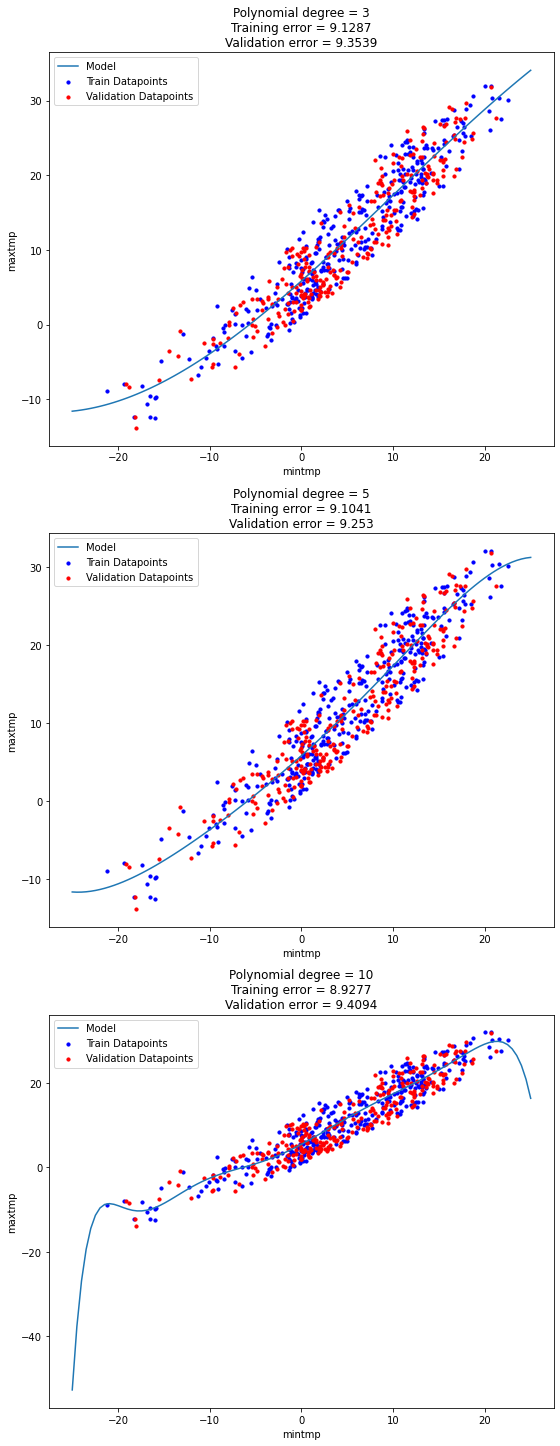

In [19]:
## define a list of values for the maximum polynomial degree 
degrees = [3, 5, 10]    

# we will use this variable to store the resulting training and validation errors for each polynomial degree
tr_errors, val_errors = [], []

plt.figure(figsize=(8, 20))    # create a new figure with size 8*20
for i, degree in enumerate(degrees):    # use for-loop to fit polynomial regression models with different degrees
    plt.subplot(len(degrees), 1, i + 1)    # choose the subplot
    
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
 
    poly = PolynomialFeatures(degree=degree)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit and transform the raw features
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    
    # y_pred_train = ...    # predict values for the training data using the linear model
    # tr_error = ...    # calculate the training error
    # X_val_poly = ... # transform the raw features for the validation data 
    # y_pred_val = ... # predict values for the validation data using the linear model 
    # val_error = ... # calculate the validation error
    
    # YOUR CODE HERE
    y_pred_train = lin_regr.predict(X_train_poly)    # predict values for the training data using the linear model
    tr_error = mean_squared_error(y_pred_train, y_train)       # calculate the training error
    X_val_poly = poly.transform(X_val) # transform the raw features for the validation data 
    y_pred_val = lin_regr.predict(X_val_poly)  # predict values for the validation data using the linear model 
    val_error = mean_squared_error(y_pred_val, y_val)
    
    # sanity check the feature matrix is transformed correctly
    assert X_val_poly.shape == (X_val.shape[0], degree + 1), "The dimension of new feature vector is incorrect" 
    # sanity check the error values
    assert 8 < tr_error < 10 and 8 < val_error < 12
    
    tr_errors.append(tr_error)
    val_errors.append(val_error)
    
    X_fit = np.linspace(-25, 25, 100)    # generate samples
    plt.tight_layout()
    plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model")    # plot the polynomial regression model
    plt.scatter(X_train, y_train, color="b", s=10, label="Train Datapoints")    # plot a scatter plot of y(maxtmp) vs. X(mintmp) with color 'blue' and size '10'
    plt.scatter(X_val, y_val, color="r", s=10, label="Validation Datapoints")    # do the same for validation data with color 'red'
    plt.xlabel('mintmp')    # set the label for the x/y-axis
    plt.ylabel('maxtmp')
    plt.legend(loc="best")    # set the location of the legend
    plt.title(f'Polynomial degree = {degree}\nTraining error = {tr_error:.5}\nValidation error = {val_error:.5}')    # set the title
    
plt.show()    # show the plot

# sanity check the length of array tr_errors
assert len(tr_errors) == len(val_errors) == len(degrees)

In [20]:
# this is the 1st test cell for A5.2


In [21]:
for i, degree in enumerate(degrees):
    print(f"For polynomial degree {degree}: the training error is {tr_errors[i]}, the validation error is {val_errors[i]}")

For polynomial degree 3: the training error is 9.128680532620562, the validation error is 9.35393616032128
For polynomial degree 5: the training error is 9.104076276390922, the validation error is 9.253001720352678
For polynomial degree 10: the training error is 8.927689630261082, the validation error is 9.409375966372131


#### Obtaining final test error
As we can see, due to the validation error the best Polynomial model is with degree of 5. After that, the final error on test set is calculated for the best model.

In [26]:
lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
 
poly = PolynomialFeatures(degree=5)    # generate polynomial features with degree of 5
X_train_poly = poly.fit_transform(X_train)    # fit the raw features
lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    
## Polinomial transforming raw features of test set and evaluate model performance on test data:    
X_test_poly = poly.transform(X_test)   # transform the raw features for the test data 
y_pred_test = lin_regr.predict(X_test_poly) # predict values for the test data using the linear model 
test_error = mean_squared_error(y_pred_test, y_test)   # calculate the test error


print("The test error is: ",test_error)

The test error is:  11.723735778940444


In [27]:
# this is the 2nd test cell for A5.2


<div class=" alert alert-warning">
    
# Task A5.3:
This task shows that different division into training and validation data can result in different validation errors for the model with same parameters.<br>
    
In this task the polynomial regression with the degree of 5 is learnt several times on slightly different subsets of original dataset and validation errors are calculated. Let's see how these validation errors are distributed.<br>

The [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from sklearn.model_selection is used. It provides train/validation indices to split data in train/validation sets. In our case dataset is shuffled and split into k=20 consecutive folds, each fold is then used once as a validation while the k - 1 remaining folds form the training set.
</div>

In [29]:
# Initialize KFold with 20 splits and random_state=42. Set shuffle=True
cv = KFold(n_splits=20, random_state=42, shuffle=True)

validation_errors = [] # store the validation errors

# Iterate through the indices of train and validation (iteration through each split of 20)
for train_index, val_index in cv.split(y):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
     
    
    poly = PolynomialFeatures(degree=5)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit the raw features

    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
 
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    
    X_val_poly = poly.transform(X_val)  # transform the raw features for the validation data 
    y_pred_val = lin_regr.predict(X_val_poly) # predict values for the validation data using the linear model 
    val_error = mean_squared_error(y_pred_val, y_val)   # calculate the validation error
    
    validation_errors.append(val_error)

    
# sanity check the length of array val_errors
assert cv.random_state == 42, "wrong random_state of KFold splitting"
assert 3 < val_error < 4, "wrong validation error"

In [30]:
# this is the 1st test cell for A5.3

In [31]:
# this is the 2nd test cell for A5.3


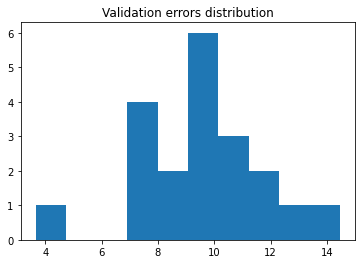

In [32]:
# Plot the distribution of the validation errors
plt.hist(validation_errors)
plt.title("Validation errors distribution")
plt.show()

<div class=" alert alert-warning">
    
# A5.4:
Answer the following quiz question by setting the corresponding variable to the index of the answer that you consider correct.

On what data part does the validation error depend?
    
 * Answer 1: Only training data
    
 * Answer 2: Only validation data
    
 * Answer 3: Both: train and validation data
</div>

In [33]:
## set your_answer to the index of the correct answer (e.g., your_answer=1 if you think Answer 1 is correct)

your_answer = 3

In [34]:
# sanity check the length of array tr_errors
assert len(str(your_answer)) == 1
assert isinstance(your_answer,int)

In [35]:
#This is the grade cell for A5.4


## Reference error

As was stated before the learning goals, it is very good if it's possible to find the reference error $E_{ref}$ to compare against the average loss on validation/test set. That error can be found in several ways.<br>
    
It can be loss incurred by predictions obtained from humans. For example, with the help of some crowdsourcing platform, like https://www.mturk.com/.<br>
    
Also one common example is widespread when working with public datasets. For many of them people have already built solutions and shared their results in such competitions, as in Kaggle. So you can just go there, find similar dataset of interest, check the leaderboard scores and assume that the best one is reference mark.
For instance, find the competition in Kaggle for Zillow Prize: Zillow’s Home Value Prediction (Zestimate). Go the leaderboard and find the smallest MAE score achieved by competitors. That can also be the reference score.<br>
    
Another variant is connected with probabilistic modelling (Bayes risk), to which A5.5 is devoted.



<div class=" alert alert-warning">
    
# Task A5.5:
<ul>  
In this task you will work with probabilistic modelling for Bayes error. The assumption here is our datapoints are from a bivariate Gaussian distribution.  It's worth mentioning that we are not fitting a Gaussian to make predictions (which we could do, of course), instead we are modelling Bayes error to explore the intrinsic uncertainty in y given x. This way we can get some idea what to expect from our model, in particular, the least average squared error of the (in a certain sense) optimal hypothesis, i.e. some benchmark for the error. 

The formula for conditional variance of $y$, given $x$ is:
 $$\sigma_{y|x}^{2}=(1-\rho^2)\sigma_{y}^{2}\space,\space \text{where}\space \space \rho = \frac{cov(x,y)}{\sigma_{x}\sigma_{y}}$$
From this formula, we can easily see that the variance of y given x is decreasing the more correlated the two variables are (the larger correlation coeficient $\rho$ is).

To make the calculation simpler, we will use an equivalent formula  for this task:
    $$var(y|x)=var(y)-cov(y,x)var(x)^{-1}cov(x,y)$$
    

**The steps are**:
    <ul>
    <li>Fit a (bivariate) Gaussian distribution p(x,y) to the dataset and obtain a covariance matrix. Numpy provides the function [np.cov()](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) to calculate a covariance matrix. Please set the parameter `ddof=1` (degree of freedom) in order to get unbiased estimators of variances and covariance. the resulted covariance matirx is a symmetric matrix, its main diaganol contains variance of $x$ and $y$, off-diaganol entries are covariance between $x$ and $y$.</li>
    <li>Calculate the conditional variance $var(y|x)$ by using unbiased estimates of the variances and covariance you can access from the covariance matrix obtained in last step.
    </li>
    </ul>
    
    
More detailed information about conditional variance of Gaussian distribution could be found in Wikipedia page: https://en.wikipedia.org/wiki/Multivariate_normal_distribution.

</div>


In [36]:
# Sample preparation. We will use X and y from FMI data, but name them as x1 and y1. 
# First reshape X back to a vecotor and then construct a data matrix with 2 rows, corresponding to x1,y1 respectively.

x1 = X.reshape(-1)  
y1 = y
data_matrix = np.stack([x1,y1], axis=0) # data matrix with 2 rows, corresponding to x1,y1 respectively.
print(x1.shape)
print(y1.shape)
print(data_matrix.shape)

(713,)
(713,)
(2, 713)


In [37]:
## Use Numpy functions to calculate covariance matrix of x1 and y1.
## check out https://numpy.org/doc/stable/reference/generated/numpy.cov.html

covariance = np.cov(data_matrix) # Covariance matrix of two rows of the data matrix. 

assert covariance.shape==(2,2),'wrong shape of covariance'   #sanity check

# A symmetric matrix, its main diaganol contains variance of x1 and y1
# off-diaganol entries are covariance between x1 and y1 
print("Covariance Matrix: \n\n",covariance) 

Covariance Matrix: 

 [[65.08407634 69.63357941]
 [69.63357941 84.48492235]]


In [38]:
#This is the grade cell for A5.5, please leave it as it is.


Compute conditional variance of y1, given x1 by using the formula:
    $$var(y|x)=var(y)-cov(y,x)var(x)^{-1}cov(x,y)$$


NOTE: For variance of x1, variance of y1 and covariance between x1 and y1, please use the corresponding entry from the covariance matrix you've just got, and $ cov(y,x)=cov(x,y)$.

In [43]:
## Compute the conditional variance of y1 given x1:

var_x1 = np.cov(x1) # variance of x1
var_y1 = np.cov(y1)             # variance of y1
cov = np.cov(x1,y1)                # covariance between x1 and y1 
condit_var = np.cov(y1,x1)         # conditional variance of y1, given x1 


print("The baseline for any other hypothesis is: ", condit_var)

The baseline for any other hypothesis is:  [[84.48492235 69.63357941]
 [69.63357941 65.08407634]]


In [44]:
#This is the grade cell for A5.5


In [45]:
print("Bayes error is: ", condit_var)
print("Test error for the best model (degree=5) is: ",test_error)
errors = {"degrees":degrees,
          "train_errors":tr_errors,
          "val_errors":val_errors,
         }
print("\n",pd.DataFrame(errors))

Bayes error is:  [[84.48492235 69.63357941]
 [69.63357941 65.08407634]]
Test error for the best model (degree=5) is:  11.723735778940444

    degrees  train_errors  val_errors
0        3      9.128681    9.353936
1        5      9.104076    9.253002
2       10      8.927690    9.409376


The baseline error can be compared with the test error for the best model in Task A5.2. We can see that the difference is not that large, our model performs rather good and some mistakes are because of the noise in data.

<div class=" alert alert-warning">
    
# A5.6:
Assume you have trained a model resulting in a small train error and a large val. error. Which of the following change will likely reduce the validation error?
    
* Answer 1: Use either more training data points or use a smaller model (e.g. polyreg with smaller degree)
* Answer 2: Use more validation data points
* Answer 3: Use a larger model (e.g. polyreg with higher degree)
</div>

In [51]:
# Type an answer number. 
your_answer2 = 1

In [50]:
# sanity check the length of array tr_errors
assert len(str(your_answer2)) == 1
assert isinstance(your_answer2,int)

In [49]:
#This is the grade cell for A5.6